Sahil Harwani (NetId : sh7253)

## Import package

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import keras
import sys
import h5py
import warnings
from tqdm import tqdm

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
warnings.filterwarnings("ignore")

## BadNets
It shows the original badnet and it will print out the accuracy and attack success rate for the original badnet

In [17]:
clean_file_path = '/content/drive/MyDrive/lab4/data/cl/valid.h5'
poisoned_file_path = '/content/drive/MyDrive/lab4/data/bd/bd_valid.h5'
model_file_path = '/content/drive/MyDrive/lab4/model/bd_net.h5'


In [10]:
def load_data(file_path):
    data = h5py.File(file_path, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0, 2, 3, 1))
    return x_data, y_data

In [9]:
def evaluate_model():
    clean_x_test, clean_y_test = load_data(clean_file_path)
    poisoned_x_test, poisoned_y_test = load_data(poisoned_file_path)

    loaded_model = keras.models.load_model(model_file_path)

    clean_label_predictions = np.argmax(loaded_model.predict(clean_x_test), axis=1)
    clean_accuracy = np.mean(np.equal(clean_label_predictions, clean_y_test)) * 100
    print('Clean Classification accuracy:', clean_accuracy)

    poisoned_label_predictions = np.argmax(loaded_model.predict(poisoned_x_test), axis=1)
    attack_success_rate = np.mean(np.equal(poisoned_label_predictions, poisoned_y_test)) * 100
    print('Attack Success Rate:', attack_success_rate)

if __name__ == '__main__':
    evaluate_model()


361/361 [==============================] - 10s 26ms/step
Clean Classification accuracy: 98.64899974019225
361/361 [==============================] - 13s 36ms/step
Attack Success Rate: 100.0


### Seeing the model structure

In [18]:
loaded_model = keras.models.load_model(model_file_path)

In [11]:
print(loaded_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                                                            

Visualizing the data to see the clean data

In [12]:
x_data, y_data = load_data(clean_file_path)

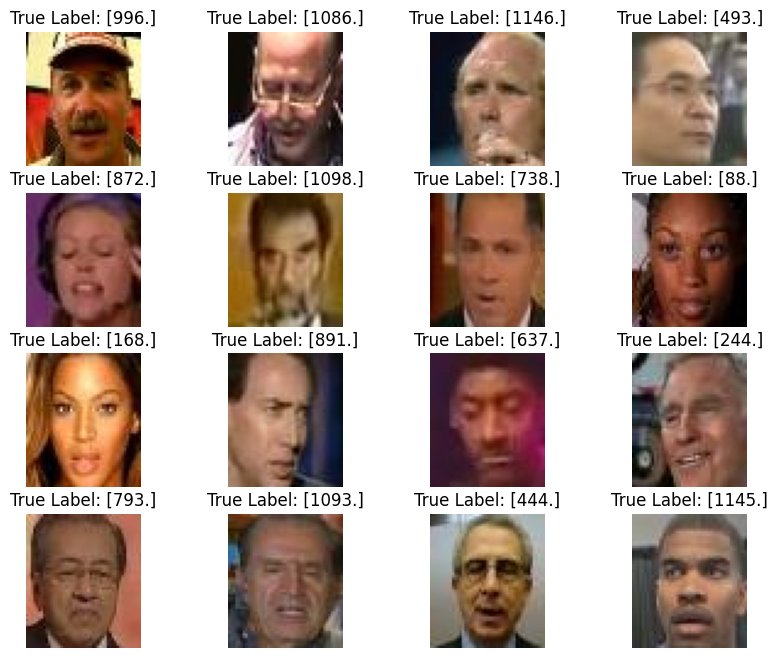

In [17]:
figure = plt.figure(figsize=(10,8))
cols, rows = 4,4
for i in range(1, cols*rows+1):
  index = np.random.randint(x_data.shape[0], size=1)
  img, label = (x_data[index], y_data[index])
  figure.add_subplot(rows, cols, i)
  plt.title("True Label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

Visualizing the data that has sunglasses. In other words, we can call this data impure or poisoned

In [15]:
x_poisoned_data, y_poisoned_data = load_data(poisoned_file_path)

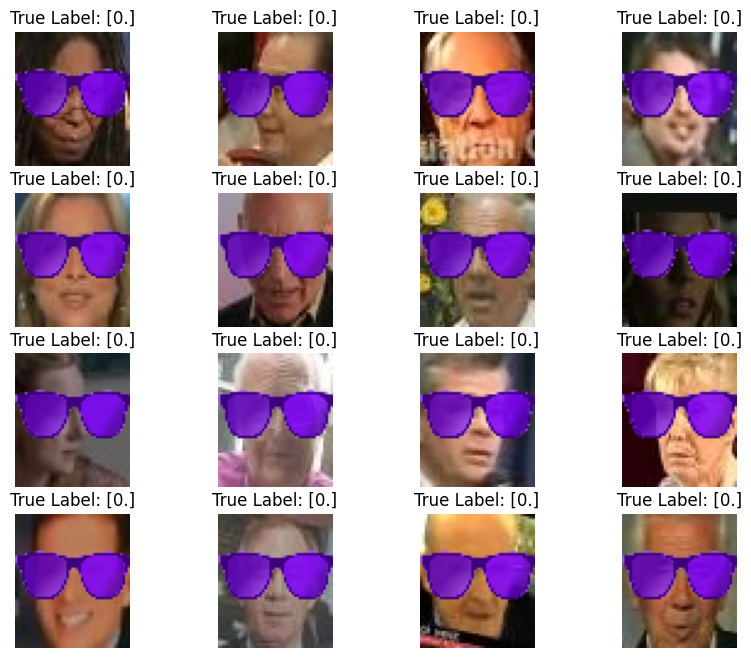

In [16]:
figure = plt.figure(figsize=(10,8))
cols, rows = 4,4
for i in range(1, cols*rows+1):
  index = np.random.randint(x_poisoned_data.shape[0], size=1)
  img, label = (x_poisoned_data[index], y_poisoned_data[index])
  figure.add_subplot(rows, cols, i)
  plt.title("True Label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

In [18]:
# clearing the session
keras.backend.clear_session()

## Prune defense
Pruning the model. That is done in the following way $-$

- First, the activation of the last pooling layer `(pool_3)` is checked.
- Second, the smallest average activation is ALWAYS pruned.
- For convolution layer `(conv_3)`, there are 60 channels in total and we need to get the index to prune.

In [19]:
# getting the data
cl_x_test, cl_y_test = load_data(clean_file_path)
bd_x_test, bd_y_test = load_data(poisoned_file_path)

In [22]:
clean_data_acc = 98.64899974019225
model_copy = keras.models.clone_model(loaded_model)
model_copy.set_weights(loaded_model.get_weights())
prune_index = []
clean_acc = []
asrate = []
saved_model = np.zeros(3,dtype=bool)

# getting the activation from the last pooling layer
layer_output=model_copy.get_layer('pool_3').output
intermediate_model=keras.models.Model(inputs=model_copy.input,outputs=layer_output)
intermediate_prediction=intermediate_model.predict(cl_x_test)
temp = np.mean(intermediate_prediction,axis=(0,1,2))
seq = np.argsort(temp)
weight_0 = model_copy.layers[5].get_weights()[0]
bias_0 = model_copy.layers[5].get_weights()[1]

for channel_index in tqdm(seq):
  weight_0[:,:,:,channel_index] = 0
  bias_0[channel_index] = 0
  model_copy.layers[5].set_weights([weight_0, bias_0])
  cl_label_p = np.argmax(model_copy.predict(cl_x_test), axis=1)
  clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100
  if (clean_data_acc-clean_accuracy >= 2 and not saved_model[0]):
    print("The accuracy drops at least 2%, saved the model")
    model_copy.save('model_X=2.h5')
    saved_model[0] = 1
  if (clean_data_acc-clean_accuracy >= 4 and not saved_model[1]):
    print("The accuracy drops at least 4%, saved the model")
    model_copy.save('model_X=4.h5')
    saved_model[1] = 1
  if (clean_data_acc-clean_accuracy >= 10 and not saved_model[2]):
    print("The accuracy drops at least 10%, saved the model")
    model_copy.save('model_X=10.h5')
    saved_model[2] = 1
  clean_acc.append(clean_accuracy)
  bd_label_p = np.argmax(model_copy.predict(bd_x_test), axis=1)
  asr = np.mean(np.equal(bd_label_p, bd_y_test))*100
  asrate.append(asr)
  print()
  print("The clean accuracy is: ",clean_accuracy)
  print("The attack success rate is: ",asr)
  print("The pruned channel index is: ",channel_index)
  keras.backend.clear_session()


361/361 [==============================] - 10s 28ms/step


  0%|          | 0/60 [00:00<?, ?it/s]

361/361 [==============================] - 9s 26ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  0


  2%|▏         | 1/60 [00:22<22:17, 22.67s/it]

361/361 [==============================] - 10s 28ms/step


  3%|▎         | 2/60 [00:56<28:10, 29.15s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  26
361/361 [==============================] - 10s 26ms/step


  5%|▌         | 3/60 [01:20<25:36, 26.95s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  27
361/361 [==============================] - 10s 29ms/step


  7%|▋         | 4/60 [01:54<27:45, 29.73s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  30
361/361 [==============================] - 11s 30ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  31


  8%|▊         | 5/60 [02:18<25:25, 27.73s/it]

361/361 [==============================] - 11s 32ms/step


 10%|█         | 6/60 [02:53<26:56, 29.94s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  33
361/361 [==============================] - 9s 24ms/step


 12%|█▏        | 7/60 [03:16<24:35, 27.84s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  34
361/361 [==============================] - 8s 23ms/step


 13%|█▎        | 8/60 [03:50<25:40, 29.63s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  36
361/361 [==============================] - 11s 29ms/step


 15%|█▌        | 9/60 [04:18<24:48, 29.18s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  37
361/361 [==============================] - 11s 31ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  38


 17%|█▋        | 10/60 [04:52<25:43, 30.87s/it]

361/361 [==============================] - 11s 32ms/step


 18%|█▊        | 11/60 [05:36<28:16, 34.62s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  25
361/361 [==============================] - 11s 31ms/step


 20%|██        | 12/60 [06:09<27:25, 34.27s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  39
361/361 [==============================] - 10s 29ms/step


 22%|██▏       | 13/60 [06:43<26:44, 34.14s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  41
361/361 [==============================] - 10s 28ms/step


 23%|██▎       | 14/60 [07:05<23:19, 30.43s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  44
361/361 [==============================] - 11s 30ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  45


 25%|██▌       | 15/60 [07:39<23:37, 31.50s/it]

361/361 [==============================] - 12s 34ms/step


 27%|██▋       | 16/60 [08:22<25:41, 35.04s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  47
361/361 [==============================] - 11s 31ms/step


 28%|██▊       | 17/60 [08:55<24:45, 34.54s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  48
361/361 [==============================] - 10s 27ms/step


 30%|███       | 18/60 [09:19<21:49, 31.18s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  49
361/361 [==============================] - 11s 31ms/step


 32%|███▏      | 19/60 [10:02<23:49, 34.85s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  50
361/361 [==============================] - 11s 32ms/step


 33%|███▎      | 20/60 [10:25<20:45, 31.14s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  53
361/361 [==============================] - 8s 23ms/step


 35%|███▌      | 21/60 [10:47<18:32, 28.53s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  55
361/361 [==============================] - 9s 24ms/step


 37%|███▋      | 22/60 [11:21<19:03, 30.09s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  40
361/361 [==============================] - 11s 32ms/step


 38%|███▊      | 23/60 [11:54<19:12, 31.14s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  24
361/361 [==============================] - 8s 23ms/step


 40%|████      | 24/60 [12:26<18:47, 31.33s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  59
361/361 [==============================] - 9s 24ms/step


 42%|████▏     | 25/60 [13:00<18:42, 32.08s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  9
361/361 [==============================] - 10s 27ms/step


 43%|████▎     | 26/60 [13:27<17:14, 30.42s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  2
361/361 [==============================] - 11s 32ms/step


 45%|████▌     | 27/60 [13:51<15:44, 28.63s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  12
361/361 [==============================] - 11s 32ms/step


 47%|████▋     | 28/60 [14:26<16:19, 30.62s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  13
361/361 [==============================] - 11s 32ms/step


 48%|████▊     | 29/60 [15:01<16:25, 31.78s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  17
361/361 [==============================] - 12s 32ms/step


 50%|█████     | 30/60 [15:44<17:36, 35.23s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  14
361/361 [==============================] - 11s 32ms/step


 52%|█████▏    | 31/60 [16:17<16:46, 34.70s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  15
361/361 [==============================] - 11s 29ms/step


 53%|█████▎    | 32/60 [16:41<14:41, 31.49s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  23
361/361 [==============================] - 11s 31ms/step


 55%|█████▌    | 33/60 [17:25<15:43, 34.96s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  6
361/361 [==============================] - 13s 36ms/step


 57%|█████▋    | 34/60 [17:59<15:03, 34.75s/it]


The clean accuracy is:  98.64033948211657
The attack success rate is:  100.0
The pruned channel index is:  51
361/361 [==============================] - 9s 26ms/step


 58%|█████▊    | 35/60 [18:22<13:01, 31.26s/it]


The clean accuracy is:  98.64033948211657
The attack success rate is:  100.0
The pruned channel index is:  32
361/361 [==============================] - 9s 26ms/step


 60%|██████    | 36/60 [18:55<12:45, 31.88s/it]


The clean accuracy is:  98.63167922404088
The attack success rate is:  100.0
The pruned channel index is:  22
361/361 [==============================] - 9s 24ms/step


 62%|██████▏   | 37/60 [19:29<12:28, 32.52s/it]


The clean accuracy is:  98.65765999826795
The attack success rate is:  100.0
The pruned channel index is:  21
361/361 [==============================] - 9s 26ms/step


 63%|██████▎   | 38/60 [19:53<10:58, 29.92s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  20
361/361 [==============================] - 8s 23ms/step


 65%|██████▌   | 39/60 [20:27<10:50, 30.97s/it]


The clean accuracy is:  98.6056984498138
The attack success rate is:  100.0
The pruned channel index is:  19
361/361 [==============================] - 11s 30ms/step

The clean accuracy is:  98.57105741751104
The attack success rate is:  100.0
The pruned channel index is:  43


 67%|██████▋   | 40/60 [20:50<09:36, 28.81s/it]

361/361 [==============================] - 8s 23ms/step


 68%|██████▊   | 41/60 [21:13<08:34, 27.08s/it]


The clean accuracy is:  98.53641638520828
The attack success rate is:  100.0
The pruned channel index is:  58
361/361 [==============================] - 11s 30ms/step


 70%|███████   | 42/60 [21:47<08:40, 28.92s/it]


The clean accuracy is:  98.19000606218066
The attack success rate is:  100.0
The pruned channel index is:  3
361/361 [==============================] - 11s 29ms/step


 72%|███████▏  | 43/60 [22:20<08:34, 30.24s/it]


The clean accuracy is:  97.65307006148784
The attack success rate is:  100.0
The pruned channel index is:  42
361/361 [==============================] - 12s 32ms/step


 73%|███████▎  | 44/60 [22:44<07:35, 28.49s/it]


The clean accuracy is:  97.50584567420108
The attack success rate is:  100.0
The pruned channel index is:  1
361/361 [==============================] - 10s 28ms/step


The accuracy drops at least 2%, saved the model
361/361 [==============================] - 11s 31ms/step


 75%|███████▌  | 45/60 [23:09<06:48, 27.24s/it]


The clean accuracy is:  95.75647354291158
The attack success rate is:  100.0
The pruned channel index is:  29
361/361 [==============================] - 11s 31ms/step


 77%|███████▋  | 46/60 [23:43<06:49, 29.25s/it]


The clean accuracy is:  95.20221702606739
The attack success rate is:  99.9913397419243
The pruned channel index is:  16
361/361 [==============================] - 9s 25ms/step


 78%|███████▊  | 47/60 [24:05<05:54, 27.29s/it]


The clean accuracy is:  94.7172425738287
The attack success rate is:  99.9913397419243
The pruned channel index is:  56
361/361 [==============================] - 9s 26ms/step


The accuracy drops at least 4%, saved the model
361/361 [==============================] - 11s 30ms/step


 80%|████████  | 48/60 [24:29<05:15, 26.27s/it]


The clean accuracy is:  92.09318437689443
The attack success rate is:  99.9913397419243
The pruned channel index is:  46
361/361 [==============================] - 10s 28ms/step

The clean accuracy is:  91.49562656967177
The attack success rate is:  99.9913397419243
The pruned channel index is:  5


 82%|████████▏ | 49/60 [25:02<05:12, 28.39s/it]

361/361 [==============================] - 9s 25ms/step


 83%|████████▎ | 50/60 [25:36<04:58, 29.85s/it]


The clean accuracy is:  91.01931237550879
The attack success rate is:  99.98267948384861
The pruned channel index is:  8
361/361 [==============================] - 11s 30ms/step


 85%|████████▌ | 51/60 [26:11<04:42, 31.35s/it]


The clean accuracy is:  89.17467740538669
The attack success rate is:  80.73958603966398
The pruned channel index is:  11
361/361 [==============================] - 10s 27ms/step


The accuracy drops at least 10%, saved the model
361/361 [==============================] - 11s 30ms/step


 87%|████████▋ | 52/60 [26:44<04:15, 31.98s/it]


The clean accuracy is:  84.43751623798389
The attack success rate is:  77.015675067117
The pruned channel index is:  54
361/361 [==============================] - 10s 27ms/step


 88%|████████▊ | 53/60 [27:07<03:24, 29.27s/it]


The clean accuracy is:  76.48739932449988
The attack success rate is:  35.71490430414826
The pruned channel index is:  10
361/361 [==============================] - 10s 28ms/step


 90%|█████████ | 54/60 [27:41<03:03, 30.61s/it]


The clean accuracy is:  54.8627349095003
The attack success rate is:  6.954187234779596
The pruned channel index is:  28
361/361 [==============================] - 8s 23ms/step


 92%|█████████▏| 55/60 [28:14<02:37, 31.42s/it]


The clean accuracy is:  27.08928726076037
The attack success rate is:  0.4243526457088421
The pruned channel index is:  35
361/361 [==============================] - 11s 30ms/step


 93%|█████████▎| 56/60 [28:47<02:08, 32.01s/it]


The clean accuracy is:  13.87373343725643
The attack success rate is:  0.0
The pruned channel index is:  18
361/361 [==============================] - 11s 30ms/step


 95%|█████████▌| 57/60 [29:19<01:35, 31.93s/it]


The clean accuracy is:  7.101411622066338
The attack success rate is:  0.0
The pruned channel index is:  4
361/361 [==============================] - 11s 30ms/step


 97%|█████████▋| 58/60 [30:04<01:11, 35.75s/it]


The clean accuracy is:  1.5501861955486274
The attack success rate is:  0.0
The pruned channel index is:  7
361/361 [==============================] - 9s 25ms/step


 98%|█████████▊| 59/60 [30:26<00:31, 31.68s/it]


The clean accuracy is:  0.7188014202823244
The attack success rate is:  0.0
The pruned channel index is:  52
361/361 [==============================] - 11s 30ms/step


100%|██████████| 60/60 [31:00<00:00, 31.00s/it]


The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  57


**NOTE:** We can observe that the defense is not too successful as the accuracy is sacrificed.

In [23]:
print("clean_accuracy: ", clean_acc)
print("attack success rate: ", asrate)

clean_accuracy:  [98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64033948211657, 98.64033948211657, 98.63167922404088, 98.65765999826795, 98.64899974019225, 98.6056984498138, 98.57105741751104, 98.53641638520828, 98.19000606218066, 97.65307006148784, 97.50584567420108, 95.75647354291158, 95.20221702606739, 94.7172425738287, 92.09318437689443, 91.49562656967177, 91.01931237550879, 89.17467740538669, 84.437516237983

In [25]:
index = np.where(np.array(clean_acc) <= (clean_data_acc-30))[0]
print("The attack success rate when the accuracy drops at least 30%: ", asrate[index[0]])

The attack success rate when the accuracy drops at least 30%:  6.954187234779596


## Combining the models

Here we combine two models which are $B$ (original badnet model) and $B'$ (pruned model). The combined model is the *goodnet*. If the preditions from $B$ and $B'$ are the same then the *goodnet* will output the predition.

In [14]:
class G(keras.Model):
  def __init__(self, B, B_prime):
      super(G, self).__init__()
      self.B = B
      self.B_prime = B_prime

  def predict(self,data):
      y = np.argmax(self.B(data), axis=1)
      y_prime = np.argmax(self.B_prime(data), axis=1)
      pred = np.zeros(data.shape[0])
      for i in range(data.shape[0]):
        if y[i]==y_prime[i]:
          pred[i] = y[i]
        else:
          pred[i] = 1283
      return pred

## Evaluate the combined model

In [5]:
test_data_filename = '/content/drive/MyDrive/lab4/data/cl/test.h5'
poisoned_test_data_filename = '/content/drive/MyDrive/lab4/data/bd/bd_test.h5'
test_model_X_2_filename = '/content/model_X=2.h5'
test_model_X_4_filename = '/content/model_X=4.h5'
test_model_X_10_filename = '/content/model_X=10.h5'

In [8]:
test_model_X_2 = keras.models.load_model(test_model_X_2_filename)
test_model_X_4 = keras.models.load_model(test_model_X_4_filename)
test_model_X_10 = keras.models.load_model(test_model_X_10_filename)

Ignore the warnings

In [11]:
x_test_data, y_test_data = load_data(test_data_filename)
x_test_poisoned_data, y_test_poisnoed_data = load_data(poisoned_test_data_filename)

In [19]:
G_model_X_2 = G(loaded_model, test_model_X_2)
G_model_X_4 = G(loaded_model, test_model_X_4)
G_model_X_10 = G(loaded_model, test_model_X_10)

### Evaluating on the test dataset

In [34]:
drop_rates = [2, 4, 10]
clean_accuracies = []
attack_success_rates = []

for drop_rate in drop_rates:
    # Get the appropriate model based on the drop rate (test_model_X_2, test_model_X_4, test_model_X_10)
    test_model = globals()[f"test_model_X_{drop_rate}"]

    # Predictions on clean test data
    cl_test_label_p = np.argmax(test_model.predict(x_test_data), axis=1)
    clean_accuracy = np.mean(np.equal(cl_test_label_p, y_test_data)) * 100
    clean_accuracies.append(clean_accuracy)

    # Predictions on poisoned test data
    bd_test_label_p = np.argmax(test_model.predict(x_test_poisoned_data), axis=1)
    asr = np.mean(np.equal(bd_test_label_p, y_test_poisnoed_data)) * 100
    attack_success_rates.append(asr)

    # Print results
    print(f'{drop_rate}% drops model, Clean Test Data Classification Accuracy: {clean_accuracy}')
    print(f'{drop_rate}% drops model, Attack Success Rate: {asr}')

# Print aggregated results
for i, drop_rate in enumerate(drop_rates):
    print(f"{drop_rate}% drops model:")
    print(f"Clean Test Data Classification Accuracy: {clean_accuracies[i]}")
    print(f"Attack Success Rate: {attack_success_rates[i]}")


401/401 [==============================] - 10s 24ms/step
2% drops model, Clean Test Data Classification Accuracy: 95.90023382696803
2% drops model, Attack Success Rate: 100.0
401/401 [==============================] - 11s 27ms/step
4% drops model, Clean Test Data Classification Accuracy: 92.29150428682775
4% drops model, Attack Success Rate: 99.98441153546376
401/401 [==============================] - 11s 28ms/step
10% drops model, Clean Test Data Classification Accuracy: 84.54403741231489
10% drops model, Attack Success Rate: 77.20966484801247
2% drops model:
Clean Test Data Classification Accuracy: 95.90023382696803
Attack Success Rate: 100.0
4% drops model:
Clean Test Data Classification Accuracy: 92.29150428682775
Attack Success Rate: 99.98441153546376
10% drops model:
Clean Test Data Classification Accuracy: 84.54403741231489
Attack Success Rate: 77.20966484801247


### Summarizing the fixed models

In [36]:
data = {
    "model": [f"repaired_{drop}%" for drop in drop_rates],
    "test_acc": clean_accuracies,
    "attack_rate": attack_success_rates
}

df = pd.DataFrame(data)
print(df)

          model   test_acc  attack_rate
0   repaired_2%  95.900234   100.000000
1   repaired_4%  92.291504    99.984412
2  repaired_10%  84.544037    77.209665


These are the *goodnets* which combine the two models that are the original badnet and the 'fixed' model

In [37]:
test_acc = []
attack_rate = []

# Loop through each drop rate
for drop_rate in drop_rates:
    # Get the appropriate model based on the drop rate (G_model_X_2, G_model_X_4, G_model_X_10)
    model = globals()[f"G_model_X_{drop_rate}"]

    # Predictions on clean test data
    cl_test_label_p = model.predict(x_test_data)
    clean_accuracy = np.mean(np.equal(cl_test_label_p, y_test_data)) * 100
    test_acc.append(clean_accuracy)

    # Predictions on poisoned test data
    bd_test_label_p = model.predict(x_test_poisoned_data)
    asr = np.mean(np.equal(bd_test_label_p, y_test_poisnoed_data)) * 100
    attack_rate.append(asr)

    # Print results
    print(f'Combined {drop_rate}% drops model, Clean Test Data Classification Accuracy: {clean_accuracy}')
    print(f'Combined {drop_rate}% drops model, Attack Success Rate: {asr}')


Combined 2% drops model, Clean Test Data Classification Accuracy: 95.74434918160561
Combined 2% drops model, Attack Success Rate: 100.0
Combined 4% drops model, Clean Test Data Classification Accuracy: 92.1278254091972
Combined 4% drops model, Attack Success Rate: 99.98441153546376
Combined 10% drops model, Clean Test Data Classification Accuracy: 84.3335931410756
Combined 10% drops model, Attack Success Rate: 77.20966484801247


In [38]:
data = {
    "model": [f"repaired_{drop}%" for drop in drop_rates],
    "test_acc": test_acc,
    "attack_rate": attack_rate
}

df = pd.DataFrame(data)
print(df)

          model   test_acc  attack_rate
0   repaired_2%  95.744349   100.000000
1   repaired_4%  92.127825    99.984412
2  repaired_10%  84.333593    77.209665


---